# Project 

The purpose of this project is to analyze taxi traffic, with respect to weather. We specifically want to focus on the top 10 neighborhoods in terms of drop-offs. We want to be able to get visualizations on taxi companies and the number of rides. Also, we are tasked to analyze the hypothesis that the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

## Importing data

In [27]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [3]:
# import data

companies = pd.read_csv('/datasets/project_sql_result_01.csv')
trips = pd.read_csv('/datasets/project_sql_result_04.csv')
weather = pd.read_csv('/datasets/project_sql_result_07.csv')

In [4]:
# view the three data frames

companies

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,2241 - 44667 - Felman Corp,3


In [5]:
trips

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
...,...,...
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538


In [6]:
weather

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


This is based on the data cleaning we have done in SQL beforehand. What is present in each data frame:

"Companies" data frame:

* Each taxi company

* The total number of trips on November 15 and November 16, 2017

"Trips" data frame: 

* The dropoff location

* The average number of rides that ended at that location in the month of November 2017

"Weather" data frame:

* The date and time of the trip (selected to be the trips taken in the Saturdays of November 2017)

* The weather condition during the trip 

    - Weather marked as "bad" includes the words "rain" or "storm" and "good" is all other weather

* The duration of the trip in seconds

## Top 10 neighborhoods

To find the top 10 neighborhoods, we will use the "Trips" data frame.

In [7]:
# check list of top 10 neighborhoods by sorting

trips.sort_values(by = 'average_trips', ascending = False).head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


In [28]:
# describe the average_trips

print('Variance:', np.var(trips['average_trips']))
trips.describe()

Variance: 2908547.9242768195


,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


What we see is that the Loop and River North are the most common destinations. There is a steep decline in the number of average trips to a destination, and it quickly becomes rather low.

Most of the locations only have a few hundred trips on average, with a mean of 600 and a median of 52. What this tells us is that we are absolutely certain that there are some locations that have extremely high values of trips in comparison to all the others. Even our top 10 destinations, with the #10 Sheffield & DePaul having 1259 trips, are all considered outliers by this metric (outlier destinations are ones with more than 726 trips, rounded from 725.7).

There is an incredibly large variance, which makes sense. From the looks of things, there are certain areas that are very common to be dropped off at, but most of them are at low values. We have a standard deviation that is higher than even our outlier threshold, after all.

Since the Loop is the central financial district, and River North is a major social district, they make sense being the top locations. Most likely, we should expect that the other, less prominent, business or social districts would have fewer trips but have a fair amount. Residential areas would all likely have similar low average trips. Getting a graph for this would make for a useful visualization.

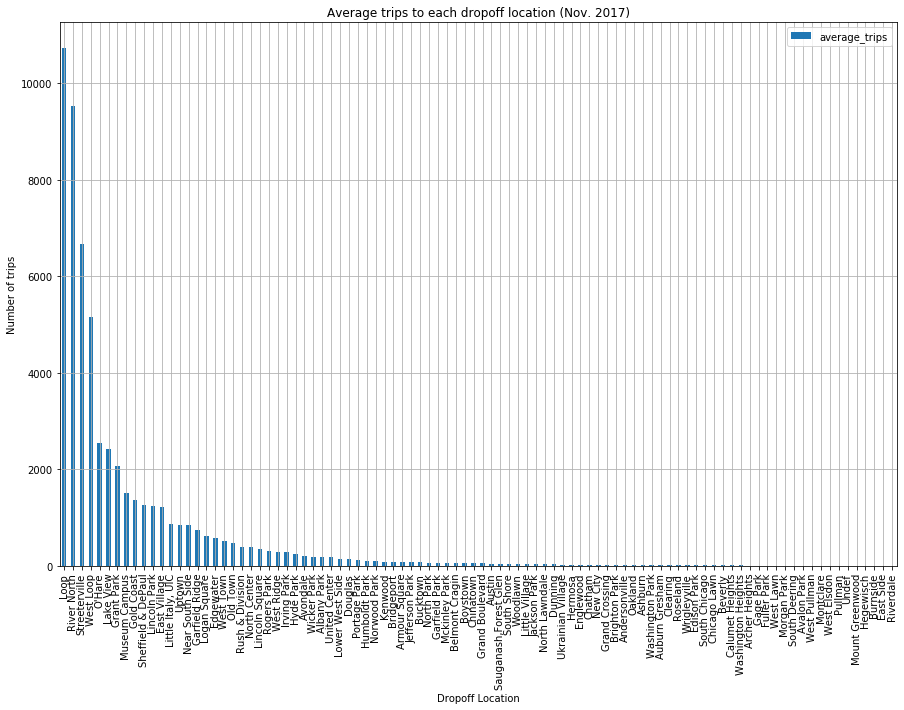

In [9]:
# bar chart

trips.sort_values(by = 'average_trips', ascending = False).plot(
    x = 'dropoff_location_name', kind = 'bar', 
    title = 'Average trips to each dropoff location (Nov. 2017)',
    grid = True, figsize = (15,10))
plt.xlabel('Dropoff Location')
plt.ylabel('Number of trips')
plt.show()

This plot shows a steep decline, but it is is absurdly large since we have so many dropoff locations. We will make a more localized plot showing the first 10 entries.

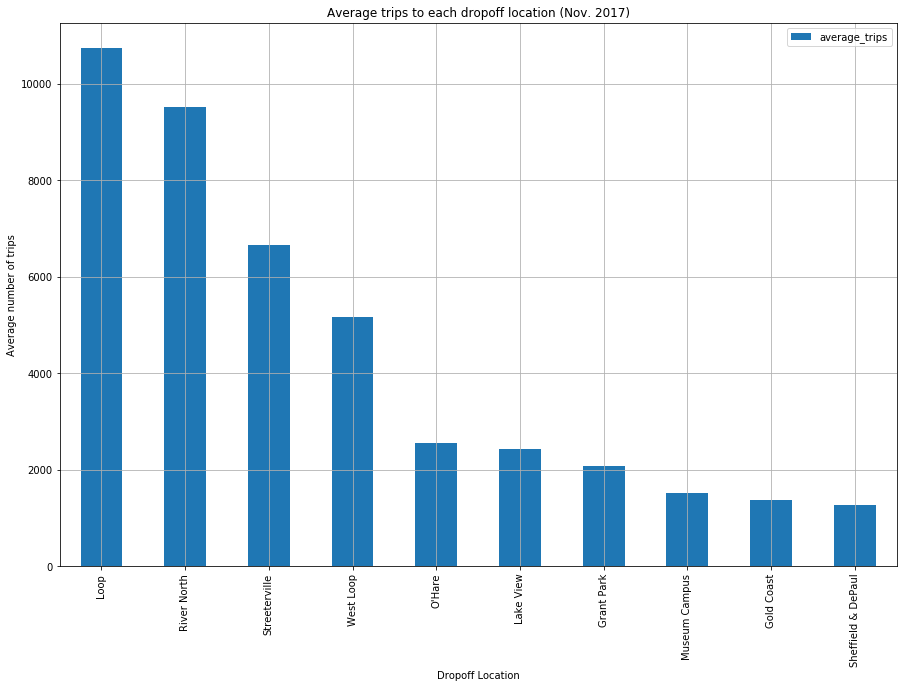

In [10]:
# zoomed in bar chart

trips.sort_values(by = 'average_trips', ascending = False)[0:10].plot(
    x = 'dropoff_location_name', kind = 'bar', 
    title = 'Average trips to each dropoff location (Nov. 2017)',
    grid = True, figsize = (15,10));
plt.xlabel('Dropoff Location')
plt.ylabel('Average number of trips')
plt.show()

For our purposes, a bar chart does show a trend but it is not the most ideal means of conveying the information. A pie chart will be much better for this, although the bar charts are still nice to have. The pie chart will give a more immediate insight into the relative size of the dropoff locations compared to one another.

Since we have a massive amount of destinations, it might also be a good idea to group together some of them to get a more clear pie chart. For any destination that isn't an outlier, we will group it into 'Other'.

In [11]:
# create data frame with dropoff location = "Other" for non-outlier dropoff locations

trips_alter = trips.copy(deep = True)

other_total = 0

for row, index in trips.iterrows():
    if trips['average_trips'][row] < 726:
        trips_alter.drop(row, axis=0, inplace=True)
        other_total += trips['average_trips'][row]
        
other_grouped = pd.DataFrame({'dropoff_location_name' : ['Other'], 'average_trips' : other_total})
        
trips_alter = trips_alter.append(other_grouped, ignore_index=True)

### Pie chart

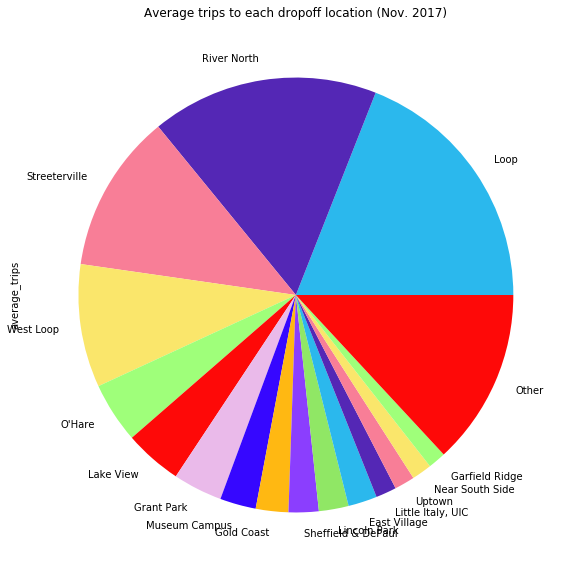

In [12]:
# pie chart

trips_alter.plot(
    x = 'dropoff_location_name', y = 'average_trips', kind = 'pie', 
    title = 'Average trips to each dropoff location (Nov. 2017)',
    labels = trips_alter['dropoff_location_name'], legend = False,
    colors = {'#eabaea','#f87e97', '#ffb812', '#5427b5','#fae66b','#9fff7a', '#2bb8ed','#90e765','#fe0908','#8b3efe','#3607ff'},
    figsize = (15,10));

## Taxi companies and number of rides

What is important when finding the data on the taxi companies is to find out generally which companies are the most dominant. We can do this largely by making another graph, and if need be we can look into the data.

In [29]:
# describe the trips_amount

print('Variance:', np.var(companies['trips_amount']))
companies.describe()

Variance: 14306619.74975586


,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


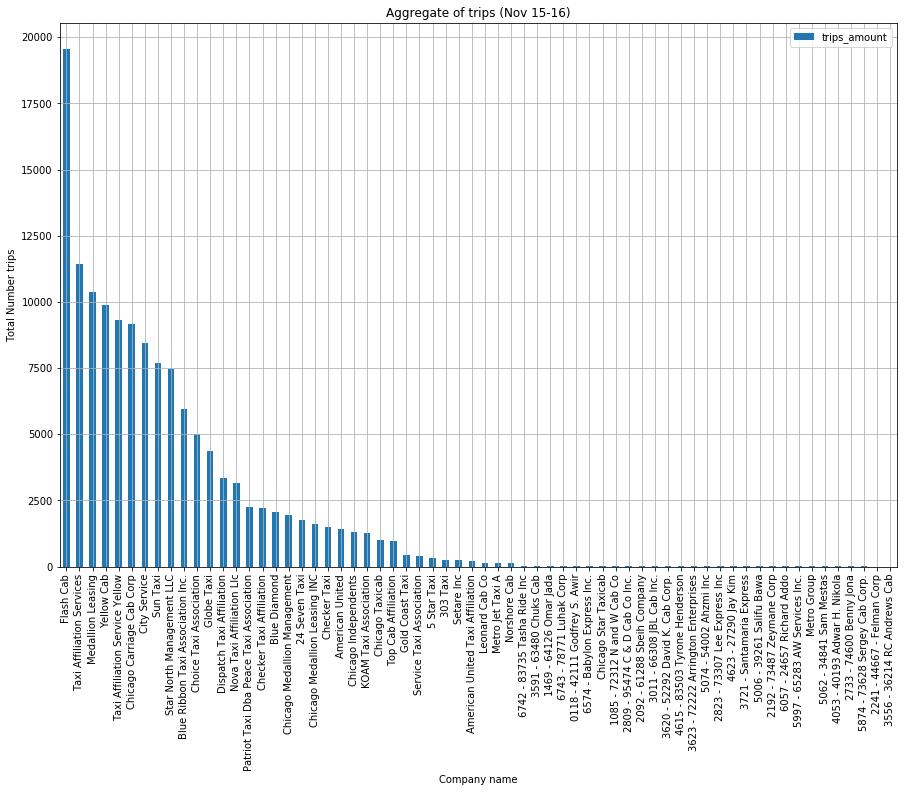

In [14]:
# bar chart

companies.sort_values(by = 'trips_amount', ascending = False).plot(
    x = 'company_name', kind = 'bar', 
    title = 'Aggregate of trips (Nov 15-16)',
    grid = True, figsize = (15,10));
plt.xlabel('Company name')
plt.ylabel('Total Number trips')
plt.show()

We see that there are a large number of moderate sized companies, but by a wide margin, Flash Cab is the most prevalent company. Again, we have an incredibly high variance. Our threshold for outliers is 5235 trips. Unlike the neighborhood data, the standard deviation is not greater than our outlier threshold but there still is a massive spread of trips across companies.

In this case, we may not necessarily need to zoom the graph in, but it will give us a different persepctive to do so.

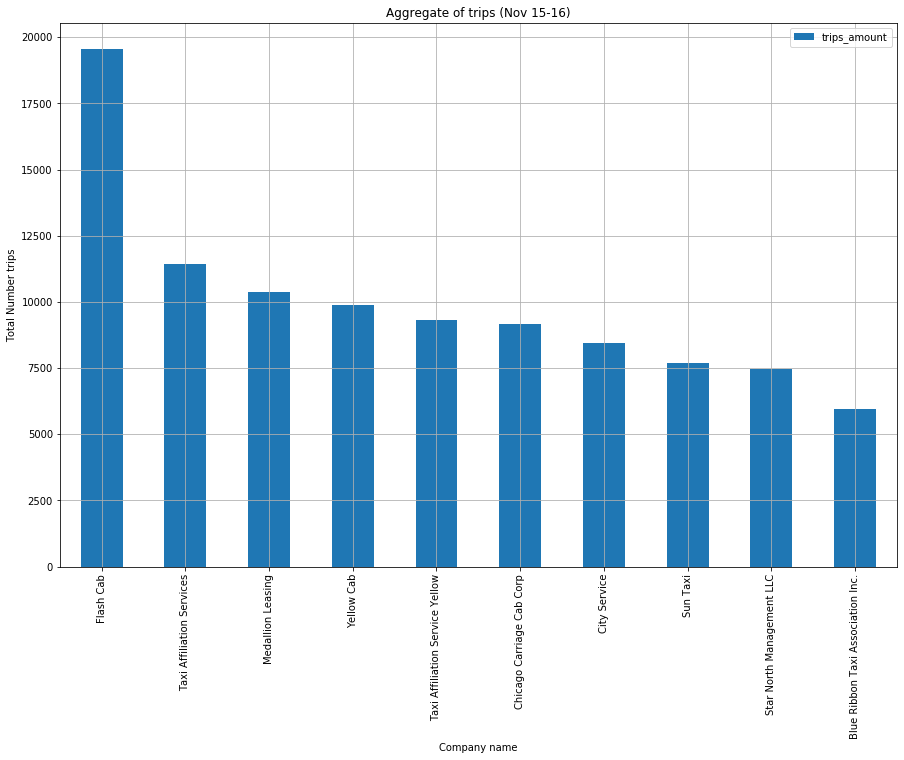

In [15]:
# zoomed in bar chart

companies.sort_values(by = 'trips_amount', ascending = False)[0:10].plot(
    x = 'company_name', kind = 'bar', 
    title = 'Aggregate of trips (Nov 15-16)',
    grid = True, figsize = (15,10));
plt.xlabel('Company name')
plt.ylabel('Total Number trips')
plt.show()

This shows something that might be worth noting. For large companies, other than Flash Cab, there is a seeming linear trend downwards as opposed to the quadratic trend across all companies. Also, with the scale altered to show shorter bars, it seems like many of the companies perform overall rather similarly in comparison to one another.

Just like we did before, we will also do an analysis of a pie chart, which will give us a more complete look at how the market is split.

Some of our earlier data cleaning was interested in comparing only Flash Cab and Taxi Affiliation Services against all the other companies. We will examine under those parameters, but also similarly to what we did in the neighborhoods, we will also see what happens if we group all non-outlier companies into the Other column.

In [17]:
# create other column

big_three = companies.copy(deep = True)

other_total = 0

for row, index in companies.iterrows():
    if companies['company_name'][row] not in ['Flash Cab', 'Taxi Affiliation Services']:
        big_three.drop(row, axis=0, inplace=True)
        other_total += companies['trips_amount'][row]
        
other_grouped = pd.DataFrame({'company_name' : ['Other'], 'trips_amount' : other_total})
        
big_three = big_three.append(other_grouped, ignore_index=True)


### Pie charts

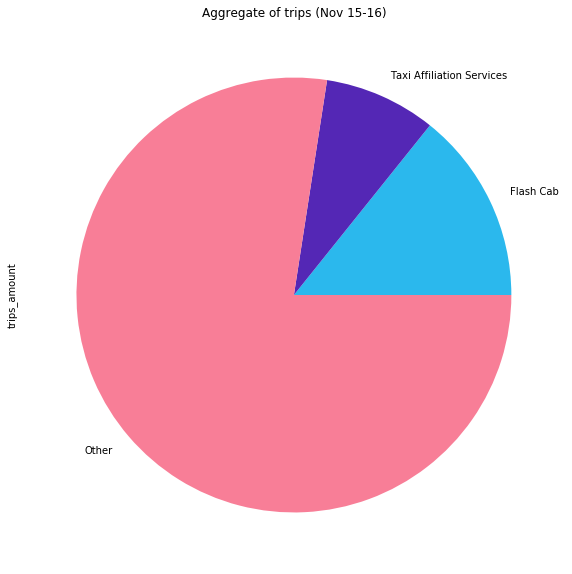

In [18]:
# pie chart

big_three.plot(
    x = 'company_name', y = 'trips_amount', kind = 'pie', 
    title = 'Aggregate of trips (Nov 15-16)',
    labels = big_three['company_name'], legend = False,
    colors = {'#eabaea','#f87e97', '#ffb812', '#5427b5','#fae66b','#9fff7a', '#2bb8ed','#90e765','#fe0908','#8b3efe','#3607ff'},
    figsize = (15,10));

While it appears from the bar graph that Flash Cab is overwhelmingly dominant, the pie chart shows that the taxi service is nowhere close to being monopolized. But with such a vast amount of small companies, it doesn't seem right to group them all into a single 'Other' category.

This pie chart gives us some information that is worth looking at, but we would get a better visualization with more companies represented. This is why, as we said before, we will do another similar pie chart with more observations, only classing companies that aren't considered outliers into the "other" category.

In [19]:
# create other column

companies_alter = companies.copy(deep = True)

other_total = 0

for row, index in companies.iterrows():
    if companies['trips_amount'][row] < 5235:
        companies_alter.drop(row, axis=0, inplace=True)
        other_total += companies['trips_amount'][row]
        
other_grouped = pd.DataFrame({'company_name' : ['Other'], 'trips_amount' : other_total})
        
companies_alter = companies_alter.append(other_grouped, ignore_index=True)

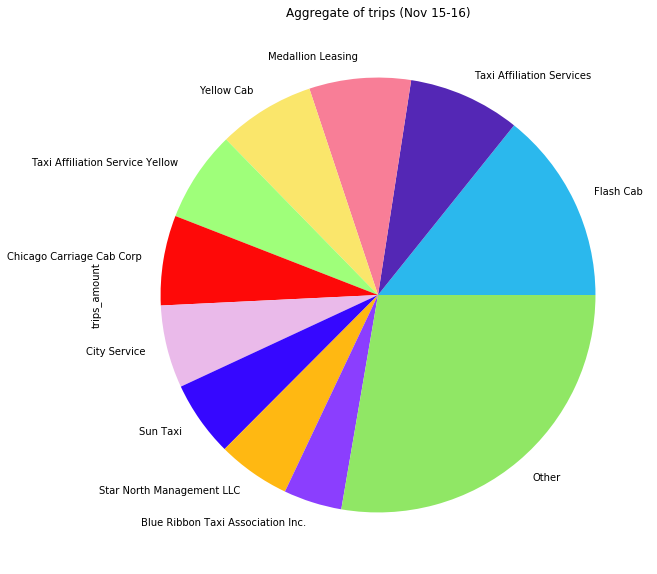

In [20]:
# pie chart

# the default palette assigned the 'Flash Cab' and 'Other' slices the same color
# thus, for readability, an alternate palette was chosen
# for consistency, this alternate palette has been applied to the other pie charts

companies_alter.plot(
    x = 'company_name', y = 'trips_amount', kind = 'pie', 
    title = 'Aggregate of trips (Nov 15-16)',
    labels = companies_alter['company_name'], legend = False,
    colors = {'#eabaea','#f87e97', '#ffb812', '#5427b5','#fae66b','#9fff7a', '#2bb8ed','#90e765','#fe0908','#8b3efe','#3607ff'},
    figsize = (15,10));

We see that there are quite a few smaller companies that are able to stand on par with one another, and while Flash Cab is the single most successful, the other companies all have a moderate share in the market. There are around 50 companies classed as "other" by our "non-outlier" metric, and they actually combine to have the largest number of rides.

## Hypothesis testing

We have one hypothesis outlined to test: whether or not the duration of rides changes on rainy Saturdays. The data we cleaned earlier already is dealing with the Saturdays in November, and is separated into rainy and non-rainy weather, so we don't need to clean it any further.

We will use a standard alpha-level of 0.05.

$$H_O: D_{rain} = D_{clear}\\
H_A: D_{rain} \neq D_{clear}\\
\alpha = 0.05$$

In [23]:
# set alpha level

alpha = 0.05

# t-test

test_one = st.ttest_ind(weather[weather['weather_conditions'] == 'Bad']['duration_seconds'], 
                        weather[weather['weather_conditions'] == 'Good']['duration_seconds'], 
                        equal_var = False)

# print means

print('Mean duration of trip (s) during rainy weather:',
      weather[weather['weather_conditions'] == 'Bad']['duration_seconds'].mean(), 
      '\nMean duration of trip (s) during clear weather:', 
      weather[weather['weather_conditions'] == 'Good']['duration_seconds'].mean(), '\n')

# check p-value

print("P-Value:", test_one.pvalue)
if test_one.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean duration of trip (s) during rainy weather: 2427.2055555555557 
Mean duration of trip (s) during clear weather: 1999.6756756756756 

P-Value: 6.738994326108734e-12
We reject the null hypothesis


We reject the null hypothesis, the average trip duration is significantly different in rainy weather. Is it greater, or less, or can we not conclude one way or the other? We can do a second, one-sided t-test to determine.

$$H_O: D_{rain} \leq D_{clear}\\
H_A: D_{rain} > D_{clear}\\
\alpha = 0.05$$

In [25]:
# print means

print('Mean duration of trip (s) during rainy weather:',
      weather[weather['weather_conditions'] == 'Bad']['duration_seconds'].mean(), 
      '\nMean duration of trip (s) during clear weather:', 
      weather[weather['weather_conditions'] == 'Good']['duration_seconds'].mean(), '\n')

# check p-value for one-sided t-test

print("P-Value:", test_one.pvalue / 2)
if (test_one.pvalue / 2) < alpha and (weather[weather['weather_conditions'] == 'Bad']['duration_seconds'].mean() 
                    > weather[weather['weather_conditions'] == 'Good']['duration_seconds'].mean()):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean duration of trip (s) during rainy weather: 2427.2055555555557 
Mean duration of trip (s) during clear weather: 1999.6756756756756 

P-Value: 3.369497163054367e-12
We reject the null hypothesis


The t-test shows that we can say that our data suggests that the trip durations are longer when it is raining.

## Conclusion

To summarize, first we cleaned our data in SQL to create data frames that we would use to answer the questions presented.

* We visualized the neighborhood of dropoff location data to analyze the top 10 most frequent destinations, and created a pie chart to view the average trips with locations with too few dropoffs being classed into "Other"

* We visualized the number of rides taken by each taxi company both via bar and pie chart. For the pie chart, we again categorized a number of our values as "Other"

* We performed a hypothesis test about the average duration of trips in rainy weather compared to clear weather and concluded that there is sufficient evidence that trips during rainy weather are, on average, longer.